In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Accessing the Electricity Demand Dataset

This notebook assumes that you have downloaded the [electricity-demand](https://huggingface.co/datasets/EDS-lab/electricity-demand/tree/main/data) dataset from HuggingFace. To execute this notebook create a folder `data/electricity-demand/` and download the 3 files into it.

Accessing the datasets from enfobench is as simple as pointing it to the right directory.

In [2]:
from enfobench.datasets import ElectricityDemandDataset

ds = ElectricityDemandDataset("../data/electricity-demand")

The `ElectricityDemandDataset` class allows you to explore the available buildings, and easily get access to the relevant data from any individual building.

In [3]:
unique_ids = ds.metadata_subset.list_unique_ids()
unique_ids[:10]

['a9aca72a511d911c',
 '8e8650aa2ec99dd4',
 '003eaf0f1786161c',
 'd5f2c7e23dd7ff3d',
 '593258347443c8b4',
 'ea9ab6ca0f38fa50',
 'dafd4b3984ed36df',
 '8ff5356daf5228a5',
 '09353ac97aa29820',
 'f1d0639a9c0111e3']

In [4]:
f"There are {len(unique_ids)} buildings available in this dataset"

'There are 7572 buildings available in this dataset'

In [5]:
unique_id = unique_ids[0]
unique_id

'a9aca72a511d911c'

To access all available data for this building you simply have to use the `.get_data_by_unique_id` method and pass in the building id.
This returns 3 objects, the `target`, `past_covariates` and the `metadata`.

In [6]:
target, past_covariates, metadata = ds.get_data_by_unique_id(unique_id)

The target is the time series data that we are interested in forecasting. It contains all available data. The format is a `pd.DataFrame` with a `pd.DatetimeIndex` and a single column named `y`.

In [7]:
target.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25029 entries, 2012-09-24 12:00:00 to 2014-02-28 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       25028 non-null  float64
dtypes: float64(1)
memory usage: 391.1 KB


The past covariates are the external data that we can use to help us forecast the target. The format is a `pd.DataFrame` with a `pd.DatetimeIndex` and multiple columns. The data were sourced from [OpenMeteo](https://open-meteo.com/). The external covariates are available for the same time period as the target.

In [8]:
past_covariates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12853 entries, 2012-09-17 12:00:00 to 2014-03-07 00:00:00
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   temperature_2m              12853 non-null  float32
 1   relative_humidity_2m        12853 non-null  float32
 2   dew_point_2m                12853 non-null  float32
 3   apparent_temperature        12853 non-null  float32
 4   precipitation               12853 non-null  float32
 5   rain                        12853 non-null  float32
 6   snowfall                    12853 non-null  float32
 7   snow_depth                  12853 non-null  float32
 8   weather_code                12853 non-null  float32
 9   pressure_msl                12853 non-null  float32
 10  surface_pressure            12853 non-null  float32
 11  cloud_cover                 12853 non-null  float32
 12  cloud_cover_low             12853 non-null  float32
 

Finally, the metadata is a dictionary that contains information about the building, such as the location building class etc.

In [9]:
metadata

{'unique_id': 'a9aca72a511d911c',
 'dataset': 'London Smart Meter Data',
 'building_id': 'MAC000007',
 'location_id': 'gcpvhftyz86u',
 'latitude': 51.5188,
 'longitude': -0.1346,
 'location': 'London, UK',
 'timezone': 'Europe/London',
 'building_class': 'Residential',
 'cluster_size': 1,
 'freq': '30T'}

# Exploratory Data Analysis

Enfobench also provides some visualization tools to help you explore the data. Here are some example visualisations of the target data.

In [10]:
import enfobench.visualization.demand as epd

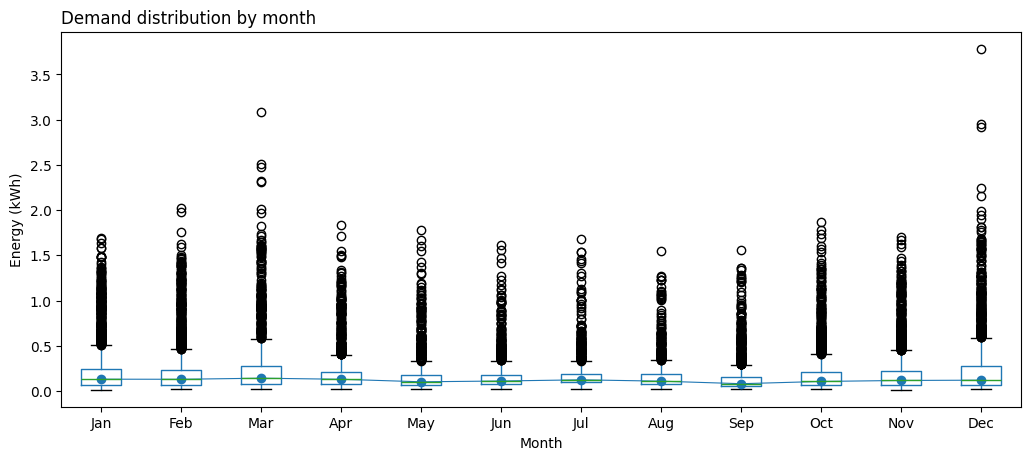

In [11]:
_ = epd.plot_monthly_box(target)

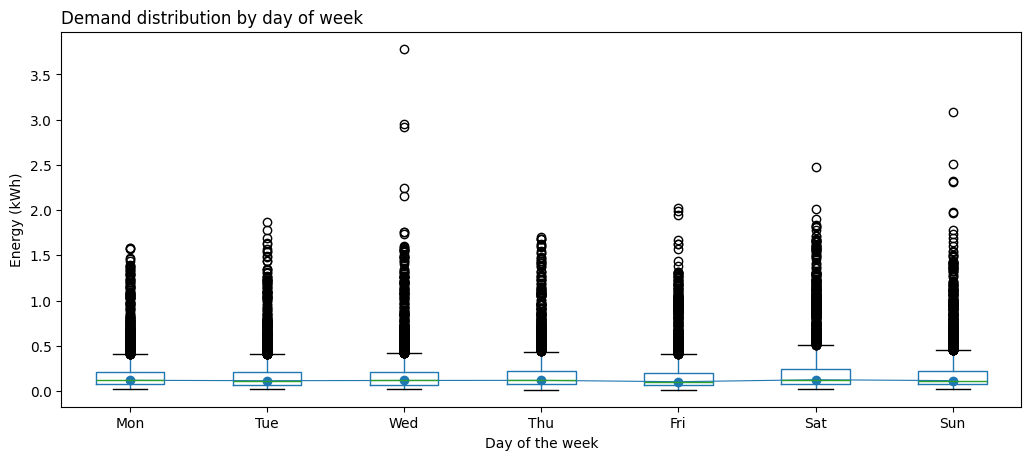

In [12]:
_ = epd.plot_weekly_box(target)

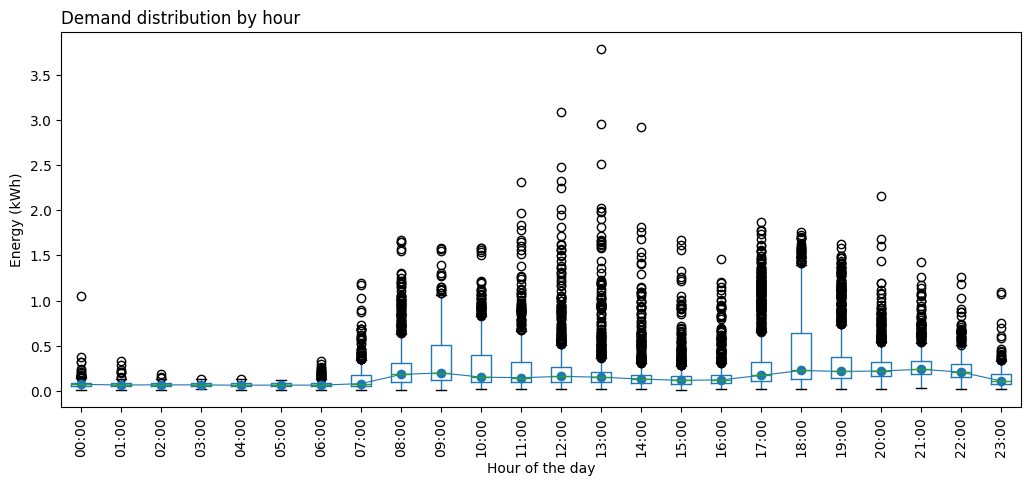

In [13]:
_ = epd.plot_daily_box(target)

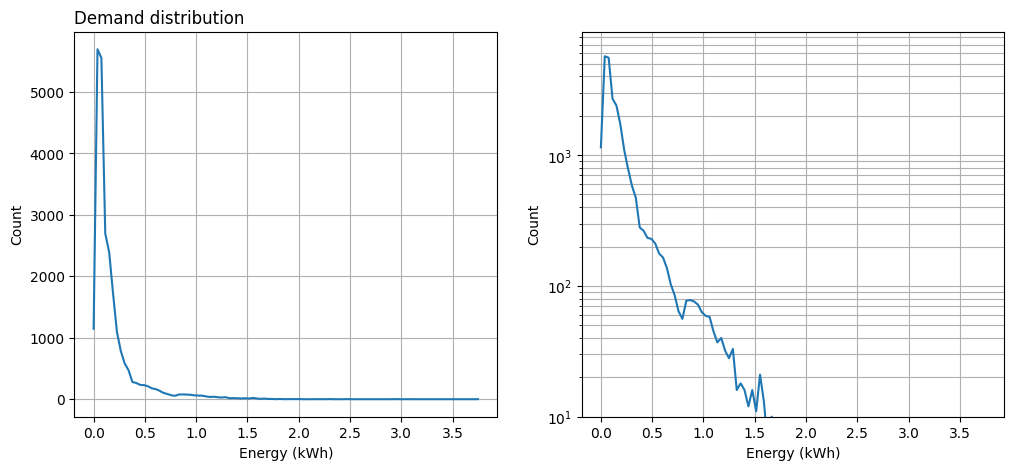

In [14]:
_ = epd.plot_histogram(target)

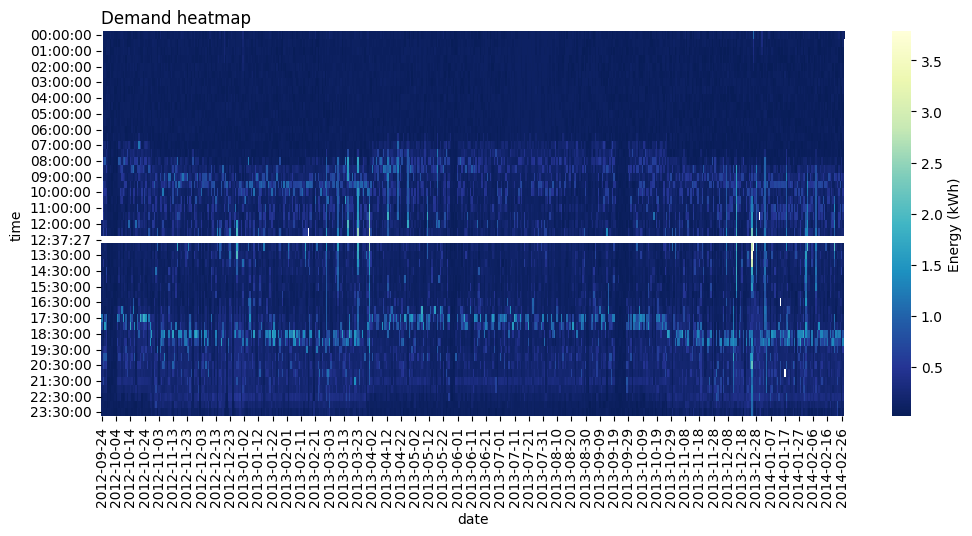

In [15]:
_ = epd.plot_heatmap(target)

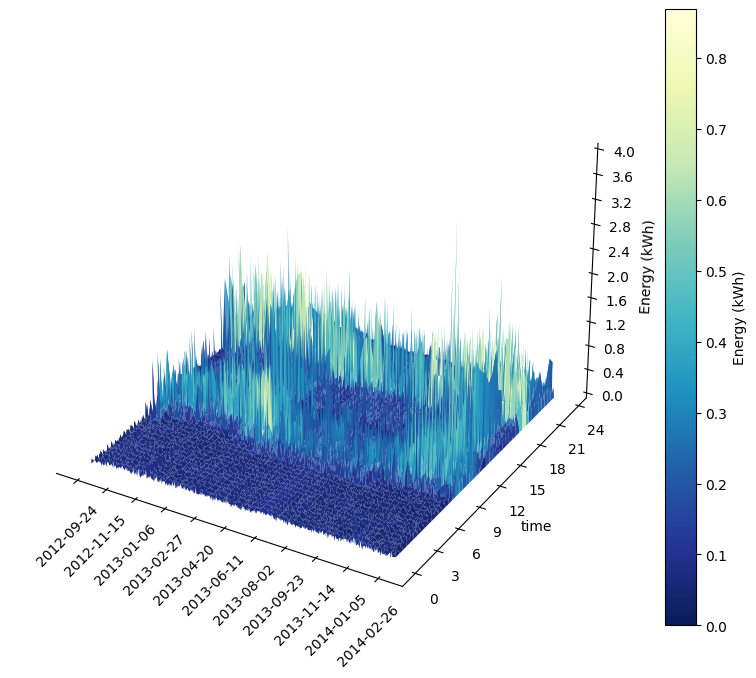

In [16]:
_ = epd.plot_3d(target)

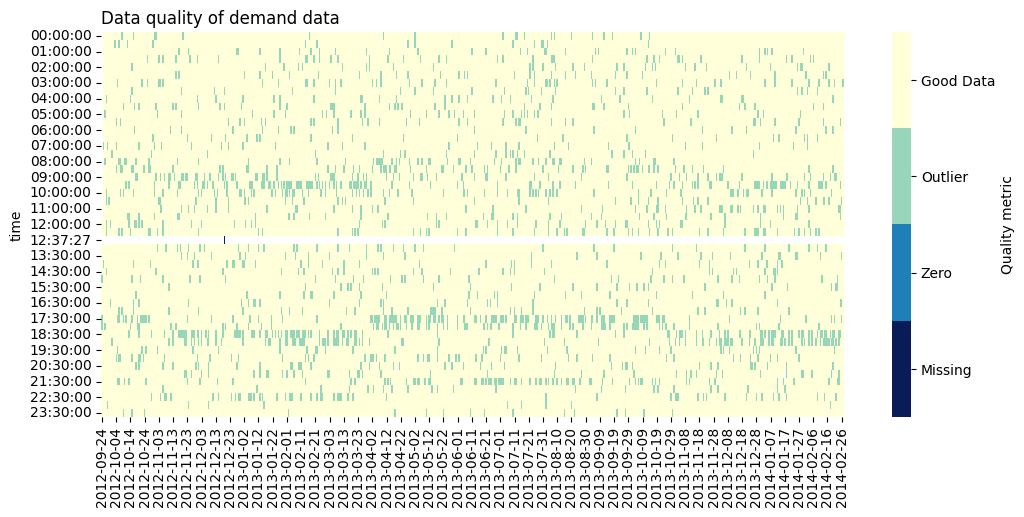

In [17]:
_ = epd.plot_data_quality(target)

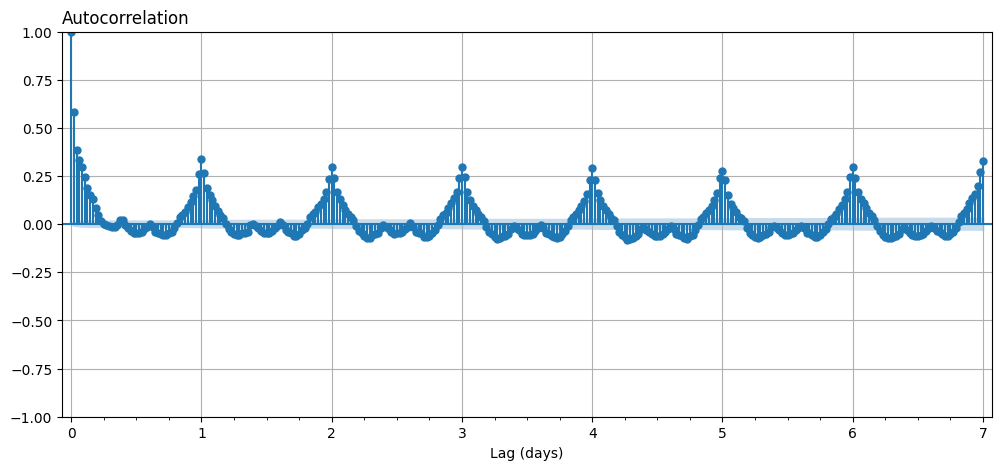

In [18]:
_ = epd.plot_acf(target.fillna(0))

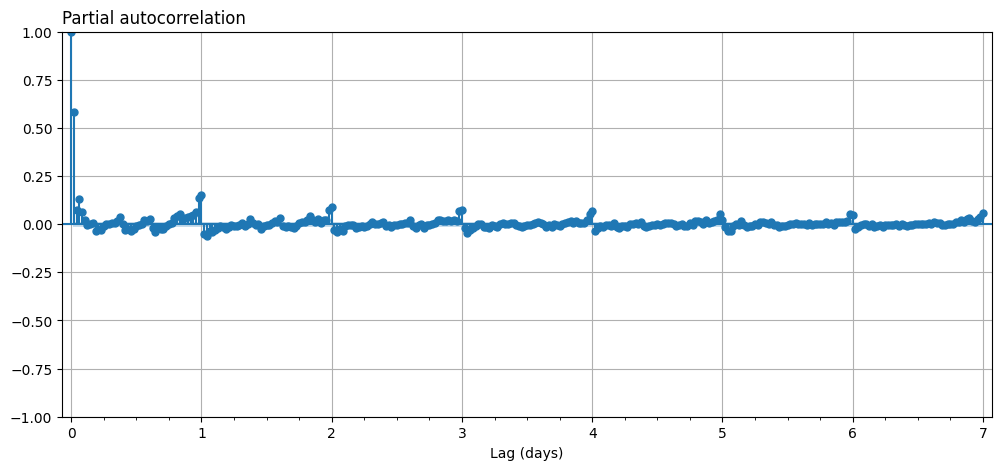

In [19]:
_ = epd.plot_pacf(target.fillna(0))

# Modeling

Modeling start by creating an `enfobench.Dataset` object. This class will help accessing the relevant data for a given forecast timestamp (cutoff-point). In this case we are only using historical values and no exogenous features so we do not have to pass in either the `past_covariates` or the `future_covariates`.

In [20]:
from enfobench import Dataset

In [21]:
univariate_dataset = Dataset(
    target=target,
    past_covariates=None,
    future_covariates=None,
    metadata=metadata,
)

The other missing piece for forecasting is the model. There is a simple interface that you need to implement in order to use it with `enfobench`. The model should implement two methods:
1. info: this should return a `ModelInfo` object that contains information about the model. These info are logged in the dashboards, but you do not need to implement this when benchmarking on your own. 
2. forecast: this should return a `pd.DataFrame` with a `pd.DatetimeIndex` and at least a column named `yhat` containing the point forecast values. For interval and probabilistic forecasts there will be additional columns, but we don't worry about it for now.

The forecast method takes in the following arguments:
- `horizon`: the forecast horizon length
- `history`: the historical slice of the `target` dataframe
- `past_covariates`: the historical slice of the `past_covariates` dataframe
- `future_covariates`: the most recent slice of the `future_covariates` dataframe
- `metadata`: the metadata dictionary
- `**kwargs`: additional arguments such as `level` for interval forecasts

Let's create a simple model that uses the mean of the last 7 days as forecast.

In [22]:
from enfobench.evaluation.utils import create_forecast_index, periods_in_duration

In [23]:
class ExampleHistoricalMeanModel:

    def forecast(
        self,
        horizon: int,
        history: pd.DataFrame,
        metadata: dict | None = None,
        **kwargs,
    ):
        N = periods_in_duration(history.index, "7D")
        mean = history.iloc[-N:].y.mean()

        return pd.DataFrame(
            index=create_forecast_index(history, horizon),
            data={
                "yhat": np.full(horizon, fill_value=mean),
            },
        )

In [24]:
model = ExampleHistoricalMeanModel()

# Evaluation

Now let's perform a cross-validation using this model and the dataset we created earlier. We will use a 38-hour horizon and a 1-day step between forecasts.
Enfobench provides a simple interface to perform cross-validation. The `cross_validate` function takes in two main arguments, the `model` and the `dataset`. It also takes in the additional keyword arguments:
- `start_date`: the start date of the cross-validation (first cutoff-date)
- `end_date`: the end date of the cross-validation (the last data point to forecast)

None of the forecasts will exceed the `end_date`, so you can set it to the last available target date.

In [25]:
from enfobench.evaluation import cross_validate

In [26]:
crossval_df = cross_validate(
    model,
    univariate_dataset,
    start_date=pd.Timestamp("2013-06-01T10:00:00"),
    end_date=pd.Timestamp("2013-07-01T00:00:00"),
    horizon=pd.Timedelta("38 hours"),
    step=pd.Timedelta("1 day"),
)

100%|██████████| 29/29 [00:00<00:00, 304.07it/s]


The cross-validation returns a `pd.DataFrame` with the following columns:
- `cutoff_date`: the timestamp of the cutoff date (forecast date)
- `timestamp`: the timestamp of the forecast
- `y`: the actual target value
- `yhat`: the forecasted value

In [27]:
crossval_df.head()

,cutoff_date,timestamp,yhat,y
0,2013-06-01 10:00:00,2013-06-01 10:30:00,0.115973,0.389
1,2013-06-01 10:00:00,2013-06-01 11:00:00,0.115973,0.094
2,2013-06-01 10:00:00,2013-06-01 11:30:00,0.115973,0.170
3,2013-06-01 10:00:00,2013-06-01 12:00:00,0.115973,0.081
4,2013-06-01 10:00:00,2013-06-01 12:30:00,0.115973,0.318


In [28]:
import matplotlib.animation as animation

plt.rcParams["animation.html"] = "jshtml"

In [29]:
plt.ioff()
fig, ax = plt.subplots(figsize=(12, 5))

cutoff_dates = crossval_df.cutoff_date.unique()


def animate_forecast(t):
    plt.cla()

    cutoff_date = cutoff_dates[t]
    history = univariate_dataset.get_history(cutoff_date)
    forecast = (
        crossval_df.loc[crossval_df.cutoff_date == cutoff_date].set_index("timestamp").drop(columns=["cutoff_date"])
    )

    ax.plot(history.index, history.y)
    ax.plot(forecast.index, forecast.yhat)
    ax.set_xlim(cutoff_dates[0] - pd.Timedelta('7D'), crossval_df.timestamp.max())
    ax.set_ylabel("Energy (kWh)")
    ax.set_title(f"Predicted energy consumption at {cutoff_date}", fontsize="large", loc="left")


ani = animation.FuncAnimation(fig, animate_forecast, frames=len(cutoff_dates))
ani

In [30]:
plt.ion()
plt.close()

Now that we have the cross-validation results we can evaluate the model using the `evaluate_metrics` function. This function takes in the `crossval_df` and a dictionary of metrics to evaluate. The metrics should be functions that take in two arguments, the actual values and the forecasted values. Enfobench provides a set of metrics that you can use, but you can also define your own or just use ones available in `numpy` or `sklearn`.

In [35]:
from enfobench.evaluation import evaluate_metrics
from enfobench.evaluation.metrics import mean_absolute_error, mean_bias_error

In [36]:
overall_metrics = evaluate_metrics(crossval_df, metrics={"MAE": mean_absolute_error, "MBE": mean_bias_error})
overall_metrics

,MAE,MBE,weight
0,0.105111,-0.018074,1.0


You can also evaluate the metrics per cutoff date by passing in the `groupby` argument. This will return a `pd.DataFrame` with the metrics for each cutoff date. It can be useful to see how the model performs over time or if there are any specific days where the model performs poorly.

In [37]:
metrics_per_cutoff = evaluate_metrics(
    crossval_df,
    metrics={"MAE": mean_absolute_error, "MBE": mean_bias_error},
    groupby="cutoff_date",
)
metrics_per_cutoff.head()

100%|██████████| 29/29 [00:00<00:00, 418.83it/s]


,cutoff_date,MAE,MBE,weight
0,2013-06-01 10:00:00,0.082713,-0.047158,1.0
1,2013-06-02 10:00:00,0.079154,-0.044732,1.0
2,2013-06-03 10:00:00,0.099622,-0.073696,1.0
3,2013-06-04 10:00:00,0.105680,-0.063191,1.0
4,2013-06-05 10:00:00,0.108774,-0.064438,1.0


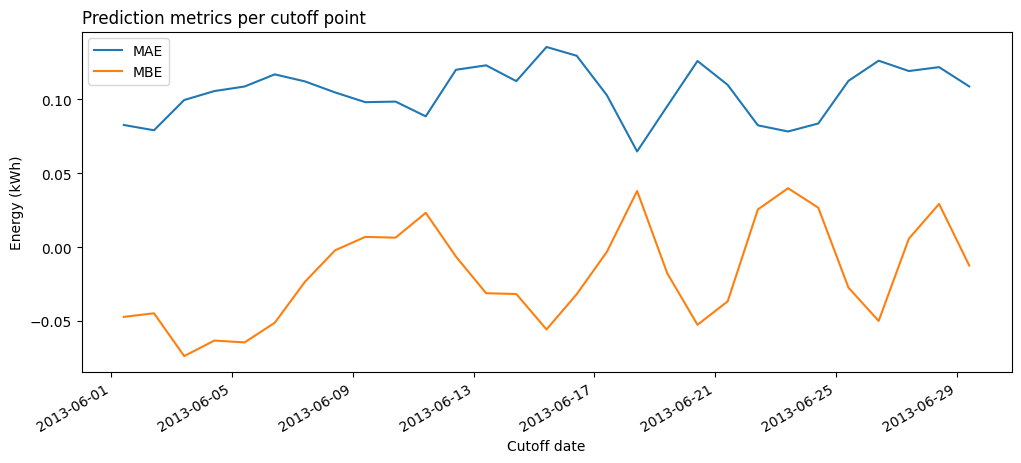

In [38]:
fig, ax = plt.subplots(figsize=(12, 5))
metrics_per_cutoff.set_index("cutoff_date")[["MAE", "MBE"]].plot(ax=ax)
ax.set_xlabel("Cutoff date")
ax.set_ylabel("Energy (kWh)")
ax.set_title("Prediction metrics per cutoff point", fontsize="large", loc="left")
plt.show()